# Calibrate QICK units

QICK (and therefore Qibosoq) uses arbitrary units to set the amplitudes of its pulses.
It is not easy to directly connect a specific value of amplitude to a physical one in volt or dBm because this depends on two factors:

- The frequency
- The reconstruction waveform employed (what the DAC syntesise between two samples)

In this document we will present a way of calibrating these units from the values measured using a Spectrum Analyzer.
The final objective is to have a function that, given a frequency and an amplitude, returns the corresponding dBm value.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### Measured data

Data taken with a simple QICK script with a continuous tone. In this case a RFSoC4x2 was used.

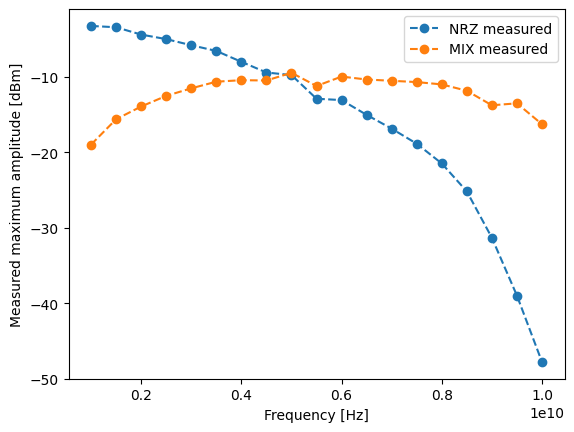

In [ ]:
# measured values for the non-return-to-zero mode (optimal for nqz=1)
# first column is the frequency, second is the value in dBm
measured_nrz = [    
    (1, -3.22),
    (1.5, -3.4),
    (2, -4.37),
    (2.5, -4.97),
    (3, -5.78),
    (3.5, -6.54),
    (4, -7.98),
    (4.5, -9.4),
    (5, -9.74),
    (5.5, -12.88),
    (6, -13.06),
    (6.5, -15.02),
    (7, -16.85),
    (7.5, -18.85),
    (8, -21.47),
    (8.5, -25.18),
    (9, -31.33),
    (9.5, -39),
    (10, -47.8),
]

# measured values for the mix mode (optimal for nqz=2)
# first column is the frequency, second is the value in dBm
measured_mix = [
    (1, -18.96),
    (1.5, -15.6),
    (2, -13.91),
    (2.5, -12.5),
    (3, -11.5),
    (3.5, -10.62),
    (4, -10.42),
    (4.5, -10.46),
    (5, -9.44),
    (5.5, -11.19),
    (6, -9.94),    
    (6.5, -10.33),
    (7, -10.50),
    (7.5, -10.67),
    (8, -10.98),
    (8.5, -11.82),
    (9, -13.75),
    (9.5, -13.49),
    (10, -16.26),
]

freqs = np.array([i[0] for i in measured_nrz])
data = [i[1] for i in measured_nrz]
plt.plot(freqs*1e9, data, "o--", label="NRZ measured")

freqs = np.array([i[0] for i in measured_mix])
data = [i[1] for i in measured_mix]
plt.plot(freqs*1e9, data, "o--", label="MIX measured")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Measured maximum amplitude [dBm]")   
plt.legend()

### Reconstruction Waveform

The first theoretical component to consider is the reconstruction waveform. 
Each RW (Reconstruction Waveform) has  different output attenuation for each frequency. We here consider just the two RW used in QICK.

In [ ]:
SAMP = 9.85e9
T = 1. / SAMP

def nrz(f):
    omega = f * 2 * np.pi
    x = omega * T / 2
    return  T * np.exp(-1j * x) * np.sin(x)/x
    
def mix(f):
    omega = f * 2 * np.pi
    x = omega * T / 4
    return x * T * np.exp(-1j * (omega * T - np.pi) / 2 ) * (np.sin(x)/x)**2

(-60.0, 5.0)

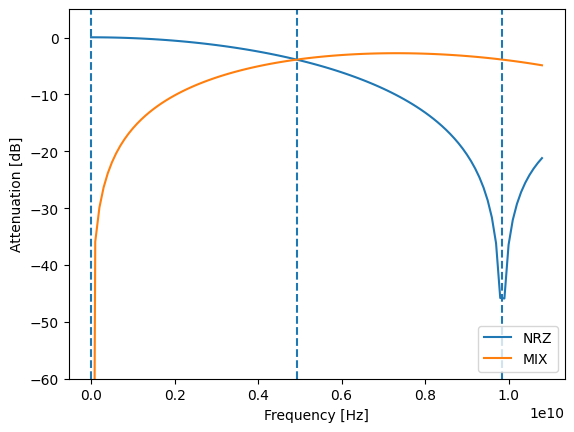

In [ ]:
def to_db(x, ref=1.01e-10):
    return (20 * np.log10(x/ref)).real

freqs = np.arange(1, 1.1*SAMP, 1e8)
plt.plot(freqs, to_db(nrz(freqs), 1.01e-10), label="NRZ")
plt.plot(freqs, to_db(mix(freqs), 1.01e-10), label="MIX")

plt.axvline(0, linestyle="--")
plt.axvline(SAMP/2, linestyle="--")
plt.axvline(SAMP, linestyle="--")


plt.xlabel("Frequency [Hz]")
plt.ylabel("Attenuation [dB]")
plt.legend()


plt.ylim(-60, 5)


### Balun attenuation

Each output of the RFSoC4x2 has a balun filter (https://cdn.macom.com/datasheets/MABA-011118.pdf) that adds some attenuation.
From its datasheet we can take some of its values and fit it to obtain an analytical function. We use a polynomial of arbitrary degree, in this case 6 since it was enough to generally describe the behaviour.

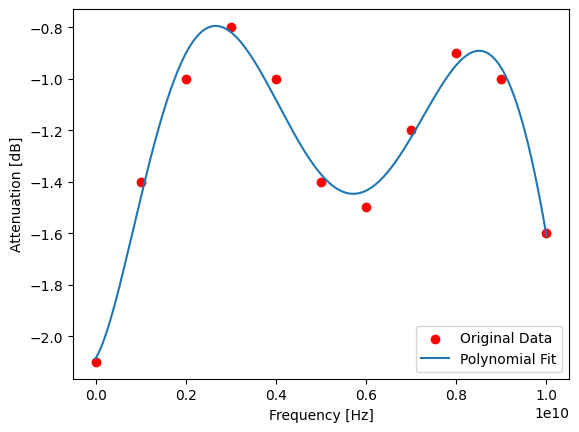

In [ ]:
# first column is frequency, second is the attenuation
balun_data = [
    (0, -2.1),
    (1, -1.4),
    (2, -1),
    (3, -0.8),
    (4, -1),
    (5, -1.4),
    (6, -1.5),
    (7, -1.2),
    (8, -0.9),
    (9, -1),
    (10, -1.6)
]

freqs = np.array([i[0] for i in balun_data])*1e9
vals = [i[1] for i in balun_data]

coeffs = np.polyfit(freqs, vals, 6)
balun_ans = np.poly1d(coeffs)
freqs_fit = np.linspace(min(freqs), max(freqs), 500)

plt.scatter(freqs, vals, color='red', label='Original Data')
plt.plot(freqs_fit, balun_ans(freqs_fit), label='Polynomial Fit')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Attenuation [dB]")
plt.legend()

### Maximum amplitude per frequency

The DACs, finally, indipendently on the RW, have a maximum power that they can output for each frequency.
We can find this by plotting the expected (DDS + balun) answer and the measured one.

In [ ]:
def dds_balun(x, func=nrz):
    return (to_db(func(x), 1.01e-10) + balun_ans(x)).real

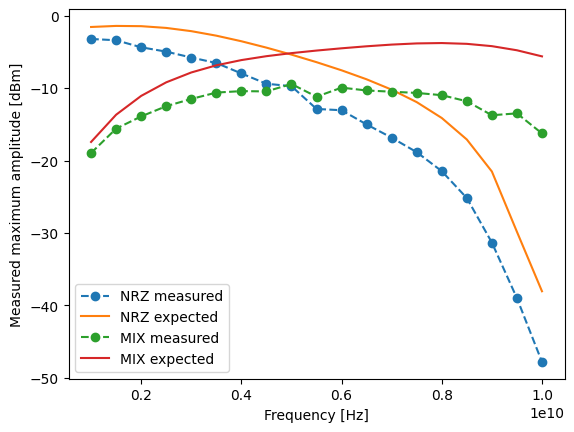

In [ ]:
freqs = np.array([i[0] for i in measured_nrz])*1e9
data = [i[1] for i in measured_nrz]
plt.plot(freqs, data, "o--", label="NRZ measured")
plt.plot(freqs, dds_balun(freqs, nrz), label="NRZ expected")

freqs = np.array([i[0] for i in measured_mix])*1e9
data = [i[1] for i in measured_mix]
plt.plot(freqs, data, "o--", label="MIX measured")
plt.plot(freqs, dds_balun(freqs, mix), label="MIX expected")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Measured maximum amplitude [dBm]")   
plt.legend()

If we look at the difference between expected and measured we can see this is almost constant in respect to the RW.
Therefore we can fit it and obtain an analytical form (again with an arbitrary polynomial):

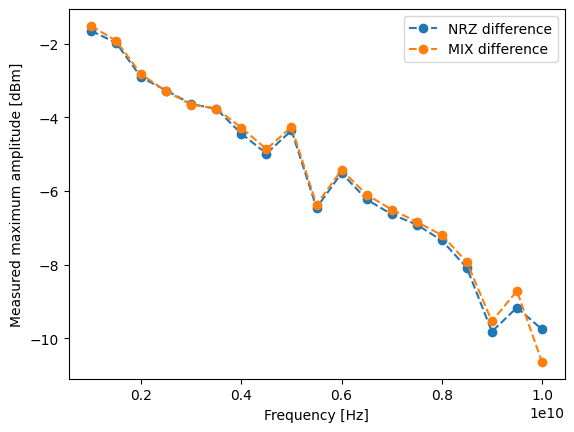

In [ ]:
freqs = np.array([i[0] for i in measured_nrz])*1e9
data = np.array([i[1] for i in measured_nrz])
plt.plot(freqs, data - dds_balun(freqs, nrz), "o--", label="NRZ difference")

freqs = np.array([i[0] for i in measured_mix])*1e9
data = np.array([i[1] for i in measured_mix])
plt.plot(freqs, data - dds_balun(freqs, mix), "o--", label="MIX difference")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Measured maximum amplitude [dBm]")   
plt.legend()

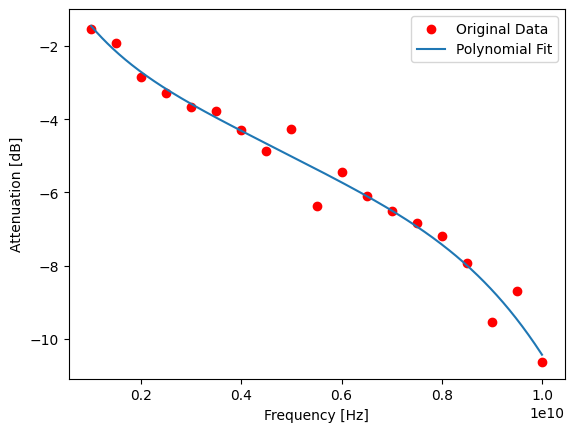

In [ ]:
coeffs_att = np.polyfit(freqs, data - dds_balun(freqs, mix), 6)
att_ans = np.poly1d(coeffs_att)

freqs_fit2 = np.linspace(min(freqs), max(freqs), 500)
# Plot the original data points
plt.scatter(freqs, data - dds_balun(freqs, mix), color='red', label='Original Data')
plt.plot(freqs_fit2, att_ans(freqs_fit2), label='Polynomial Fit')


plt.xlabel("Frequency [Hz]")
plt.ylabel("Attenuation [dB]")
plt.legend()

## Final calculation

In [ ]:
balun_ans

poly1d([ 1.51960784e-58, -5.29600302e-48,  6.59521116e-38, -3.46432367e-28,
        6.21551213e-19,  2.87256959e-10, -2.08667215e+00])

In [ ]:
att_ans

poly1d([ 3.34712268e-59, -1.43657042e-48,  2.29490068e-38, -1.89368959e-28,
        8.75578939e-19, -2.86407593e-09,  7.08743254e-01])

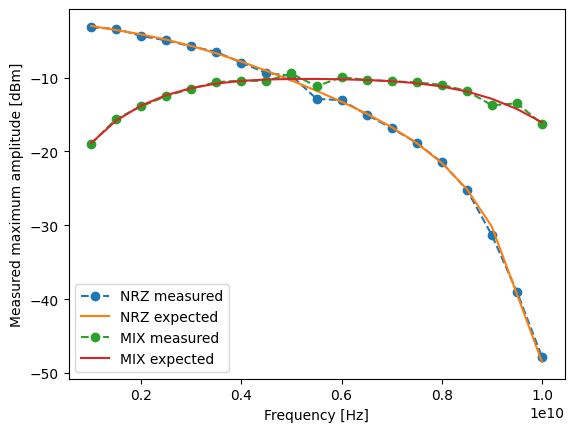

In [ ]:
def output_power(freq, func=nrz, amplitude=1):
    return (to_db(func(freq)*amplitude, 1.01e-10) + balun_ans(freq) + att_ans(freq)).real
    
freqs = np.array([i[0] for i in measured_nrz])*1e9
data = [i[1] for i in measured_nrz]
plt.plot(freqs, data, "o--", label="NRZ measured")
plt.plot(freqs, output_power(freqs, nrz), label="NRZ expected")
freqs = np.array([i[0] for i in measured_mix])*1e9
data = [i[1] for i in measured_mix]
plt.plot(freqs, data, "o--", label="MIX measured")
plt.plot(freqs, output_power(freqs, mix), label="MIX expected")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Measured maximum amplitude [dBm]")
plt.legend()